# **Statistical Information Grid (STING) Algorithm**

## **Library**

In [164]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

os.makedirs('Data', exist_ok=True)
os.makedirs('Output', exist_ok=True)

seed = 2025
np.random.seed(seed)

## **Data Preparation**

In [165]:
# Parameter untuk dataset
n_samples = 10000  # Jumlah data points
n_clusters = 5     # Jumlah cluster spasial
cluster_std = 2.0  # Standar deviasi cluster

# Generate spatial data (Latitude, Longitude) menggunakan make_blobs
X, true_labels = make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_clusters,
    cluster_std=cluster_std,
    center_box=(-50.0, 50.0),  # Range koordinat
    random_state=42
)

# Latitude: -90 to 90, Longitude: -180 to 180
latitude = X[:, 0] * 0.5  # Scale ke range -45 to 45
longitude = X[:, 1] * 1.5  # Scale ke range -75 to 75

# Timestamp
base_date = datetime.datetime(2024, 1, 1)
timestamps = [base_date + datetime.timedelta(days=np.random.randint(0, 365), 
                                            hours=np.random.randint(0, 24))
                for _ in range(n_samples)]

# Kategori
categories = np.random.choice(['A', 'B', 'C', 'D'], 
                                size=n_samples)

# Intensitas
intensity = np.zeros(n_samples)
for i in range(n_clusters):
    mask = true_labels == i
    # Setiap cluster punya range intensity berbeda
    intensity[mask] = np.random.uniform(
        1.0 + i*2, 
        5.0 + i*2, 
        size=mask.sum()
    )

In [166]:
# Buat DataFrame
df = pd.DataFrame({
    'id': range(1, n_samples + 1),
    'latitude': latitude,
    'longitude': longitude,
    'timestamp': timestamps,
    'category': categories,
    'intensity': intensity,
    'true_label': true_labels
})

df.to_csv('Data/sting_synthetic_dataset.csv', index=False)
df.head()

,id,latitude,longitude,timestamp,category,intensity,true_label
0,1,-22.513085,54.676190,2024-03-03 18:00:00,D,7.940249,3
1,2,-15.469767,-56.074062,2024-12-16 12:00:00,D,6.763073,2
2,3,11.142064,15.355838,2024-11-19 19:00:00,B,4.971661,1
3,4,11.958042,11.209099,2024-06-09 22:00:00,B,3.261399,1
4,5,-20.354436,63.454203,2024-01-11 14:00:00,B,8.227247,3


In [167]:
df.describe()

,id,latitude,longitude,intensity,true_label
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,-5.779549,23.411848,7.002051,2.000000
std,2886.89568,12.816103,41.882765,3.028222,1.414284
min,1.00000,-25.731020,-61.298518,1.000219,0.000000
25%,2500.75000,-17.864683,12.661644,4.519677,1.000000
50%,5000.50000,-6.254776,31.304328,7.028206,2.000000
75%,7500.25000,5.800492,57.012015,9.477358,3.000000
max,10000.00000,14.697997,79.385859,12.997175,4.000000


## **EDA**

### **Checking Missing Values**

In [168]:
df.isnull().sum()

id            0
latitude      0
longitude     0
timestamp     0
category      0
intensity     0
true_label    0
dtype: int64

### **Visualisasi**


Visualization saved: Output/sting_dataset_visualization.png


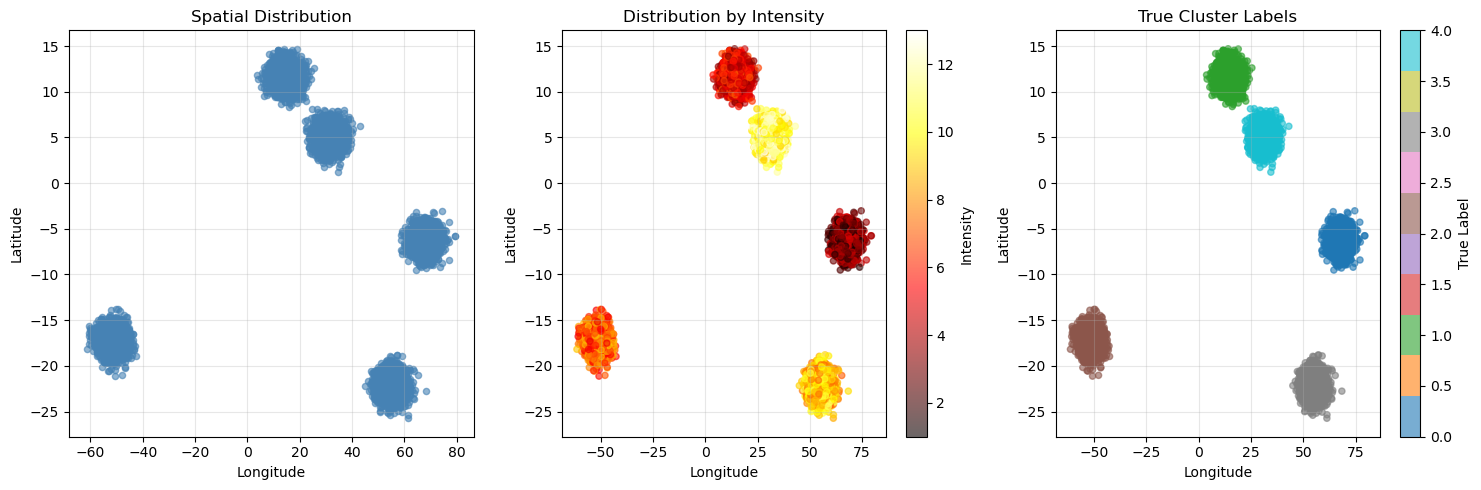

In [169]:
plt.figure(figsize=(15, 5))

# Plot 1: Basic scatter
plt.subplot(1, 3, 1)
plt.scatter(df['longitude'], df['latitude'], alpha=0.6, s=20, c='steelblue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution')
plt.grid(True, alpha=0.3)

# Plot 2: Colored by intensity
plt.subplot(1, 3, 2)
scatter = plt.scatter(df['longitude'], df['latitude'], 
                      c=df['intensity'], cmap='hot', alpha=0.6, s=20)
plt.colorbar(scatter, label='Intensity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution by Intensity')
plt.grid(True, alpha=0.3)

# Plot 3: True labels (for comparison)
plt.subplot(1, 3, 3)
scatter2 = plt.scatter(df['longitude'], df['latitude'], 
                       c=df['true_label'], cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter2, label='True Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('True Cluster Labels')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Output/sting_dataset_visualization.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved: Output/sting_dataset_visualization.png")
plt.show()

## **Preprocessing**

### **Data Cleaning**

In [170]:
# Remove invalid coordinates
original_size = len(df)
df = df[(df['latitude'] >= -90) & (df['latitude'] <= 90)]
df = df[(df['longitude'] >= -180) & (df['longitude'] <= 180)]
df = df.drop_duplicates(subset=['latitude', 'longitude'])

### **Extract Feature**

In [171]:
X = df[['latitude', 'longitude']].values

## **Modelling**

### **Calculate Grid Bounds**

In [172]:
# Parameters
grid_levels = 4
subdivision = 2
padding = 0.001

# Calculate bounds
min_lat = X[:, 0].min() - padding
max_lat = X[:, 0].max() + padding
min_lon = X[:, 1].min() - padding
max_lon = X[:, 1].max() + padding

root_bounds = {
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_lon': min_lon,
    'max_lon': max_lon
}

lat_range = max_lat - min_lat
lon_range = max_lon - min_lon

print(f"\nSpatial Bounds:")
print(f"  Latitude:  [{min_lat:.4f}, {max_lat:.4f}] (range: {lat_range:.4f})")
print(f"  Longitude: [{min_lon:.4f}, {max_lon:.4f}] (range: {lon_range:.4f})")
print(f"\nGrid Parameters:")
print(f"  Levels: {grid_levels}")
print(f"  Subdivision factor: {subdivision}")


Spatial Bounds:
  Latitude:  [-25.7320, 14.6990] (range: 40.4310)
  Longitude: [-61.2995, 79.3869] (range: 140.6864)

Grid Parameters:
  Levels: 4
  Subdivision factor: 2


### **Build Hierarchical Grid**

In [173]:
# Initialize grids
grids = []

# Create cells for each level
for level in range(grid_levels):
    n_cells = subdivision ** (level + 1)
    
    cell_height = lat_range / n_cells
    cell_width = lon_range / n_cells
    
    level_grid = {}
    
    for i in range(n_cells):
        for j in range(n_cells):
            # Calculate cell bounds
            cell_bounds = {
                'min_lat': min_lat + i * cell_height,
                'max_lat': min_lat + (i + 1) * cell_height,
                'min_lon': min_lon + j * cell_width,
                'max_lon': min_lon + (j + 1) * cell_width
            }
            
            # Create cell structure
            cell = {
                'level': level,
                'row': i,
                'col': j,
                'bounds': cell_bounds,
                'count': 0,
                'sum_x': 0.0,
                'sum_y': 0.0,
                'sum_x2': 0.0,
                'sum_y2': 0.0,
                'mean': (0.0, 0.0),
                'std': (0.0, 0.0),
                'min_vals': (float('inf'), float('inf')),
                'max_vals': (float('-inf'), float('-inf')),
                'density': 0.0,
                'points': [],
                'is_relevant': False
            }
            
            level_grid[(i, j)] = cell
    
    grids.append(level_grid)
    print(f"  Level {level}: {n_cells}×{n_cells} grid ({len(level_grid)} cells)")

  Level 0: 2×2 grid (4 cells)
  Level 1: 4×4 grid (16 cells)
  Level 2: 8×8 grid (64 cells)
  Level 3: 16×16 grid (256 cells)


### **Assign Points to Finest Level**

In [174]:
finest_level = grid_levels - 1
finest_grid = grids[finest_level]
n_cells = subdivision ** grid_levels

cell_height = lat_range / n_cells
cell_width = lon_range / n_cells

print(f"\nAssigning {len(X)} points to level {finest_level}...")
print(f"Cell dimensions: {cell_height:.4f} × {cell_width:.4f}")

# Assign each point to a cell
for idx, point in enumerate(X):
    lat, lon = point[0], point[1]
    
    # Calculate cell indices
    i = int((lat - min_lat) / cell_height)
    j = int((lon - min_lon) / cell_width)
    
    # Handle boundary cases
    i = min(max(i, 0), n_cells - 1)
    j = min(max(j, 0), n_cells - 1)
    
    # Add point to cell
    cell = finest_grid[(i, j)]
    cell['points'].append(idx)
    cell['count'] += 1
    cell['sum_x'] += lat
    cell['sum_y'] += lon
    cell['sum_x2'] += lat * lat
    cell['sum_y2'] += lon * lon
    cell['min_vals'] = (min(cell['min_vals'][0], lat), 
                        min(cell['min_vals'][1], lon))
    cell['max_vals'] = (max(cell['max_vals'][0], lat), 
                        max(cell['max_vals'][1], lon))

non_empty_cells = sum(1 for c in finest_grid.values() if c['count'] > 0)
print(f"\nPoints assigned")
print(f"Non-empty cells: {non_empty_cells}/{len(finest_grid)}")


Assigning 10000 points to level 3...
Cell dimensions: 2.5269 × 8.7929

Points assigned
Non-empty cells: 45/256


### **Compute statistics for finest level**

In [175]:
for cell in finest_grid.values():
    if cell['count'] == 0:
        continue
    
    # Mean
    cell['mean'] = (
        cell['sum_x'] / cell['count'],
        cell['sum_y'] / cell['count']
    )
    
    # Standard deviation
    var_x = (cell['sum_x2'] / cell['count']) - (cell['mean'][0] ** 2)
    var_y = (cell['sum_y2'] / cell['count']) - (cell['mean'][1] ** 2)
    var_x = max(0, var_x)
    var_y = max(0, var_y)
    cell['std'] = (math.sqrt(var_x), math.sqrt(var_y))
    
    # Density
    width = cell['bounds']['max_lon'] - cell['bounds']['min_lon']
    height = cell['bounds']['max_lat'] - cell['bounds']['min_lat']
    area = width * height
    cell['density'] = cell['count'] / area if area > 0 else 0.0

print(f"Statistics computed for level {finest_level}")

Statistics computed for level 3


### **Propagate Statistics Up**

In [176]:
# Bottom-up propagation
for level in range(grid_levels - 2, -1, -1):
    parent_grid = grids[level]
    child_grid = grids[level + 1]
    
    for (pi, pj), parent in parent_grid.items():
        # Aggregate from children
        total_count = 0
        sum_weighted_x = 0.0
        sum_weighted_y = 0.0
        sum_weighted_x2 = 0.0
        sum_weighted_y2 = 0.0
        global_min = [float('inf'), float('inf')]
        global_max = [float('-inf'), float('-inf')]
        
        for di in range(subdivision):
            for dj in range(subdivision):
                ci = pi * subdivision + di
                cj = pj * subdivision + dj
                
                if (ci, cj) in child_grid:
                    child = child_grid[(ci, cj)]
                    
                    if child['count'] > 0:
                        total_count += child['count']
                        sum_weighted_x += child['count'] * child['mean'][0]
                        sum_weighted_y += child['count'] * child['mean'][1]
                        
                        # E[X²] = σ² + μ²
                        ex2_x = child['std'][0]**2 + child['mean'][0]**2
                        ex2_y = child['std'][1]**2 + child['mean'][1]**2
                        sum_weighted_x2 += child['count'] * ex2_x
                        sum_weighted_y2 += child['count'] * ex2_y
                        
                        global_min[0] = min(global_min[0], child['min_vals'][0])
                        global_min[1] = min(global_min[1], child['min_vals'][1])
                        global_max[0] = max(global_max[0], child['max_vals'][0])
                        global_max[1] = max(global_max[1], child['max_vals'][1])
        
        if total_count > 0:
            parent['count'] = total_count
            parent['mean'] = (
                sum_weighted_x / total_count,
                sum_weighted_y / total_count
            )
            
            ex2_x = sum_weighted_x2 / total_count
            ex2_y = sum_weighted_y2 / total_count
            var_x = max(0, ex2_x - parent['mean'][0]**2)
            var_y = max(0, ex2_y - parent['mean'][1]**2)
            parent['std'] = (math.sqrt(var_x), math.sqrt(var_y))
            
            parent['min_vals'] = tuple(global_min)
            parent['max_vals'] = tuple(global_max)
            
            width = parent['bounds']['max_lon'] - parent['bounds']['min_lon']
            height = parent['bounds']['max_lat'] - parent['bounds']['min_lat']
            area = width * height
            parent['density'] = total_count / area if area > 0 else 0.0
    
    print(f"  Level {level}: Statistics propagated")

  Level 2: Statistics propagated
  Level 1: Statistics propagated
  Level 0: Statistics propagated


### **Grid Summary**

In [177]:
for level, grid in enumerate(grids):
    non_empty = sum(1 for c in grid.values() if c['count'] > 0)
    
    if non_empty > 0:
        counts = [c['count'] for c in grid.values() if c['count'] > 0]
        densities = [c['density'] for c in grid.values() if c['count'] > 0]
        
        n_cells = subdivision ** (level + 1)
        print(f"\nLevel {level}: ({n_cells}×{n_cells})")
        print(f"  Total cells: {len(grid)}")
        print(f"  Non-empty cells: {non_empty}")
        print(f"  Avg points/cell: {np.mean(counts):.1f}")
        print(f"  Max points/cell: {max(counts)}")
        print(f"  Density range: [{min(densities):.6f}, {max(densities):.6f}]")


Level 0: (2×2)
  Total cells: 4
  Non-empty cells: 4
  Avg points/cell: 2500.0
  Max points/cell: 4365
  Density range: [0.047819, 3.069570]

Level 1: (4×4)
  Total cells: 16
  Non-empty cells: 8
  Avg points/cell: 1250.0
  Max points/cell: 3272
  Density range: [0.191277, 9.203787]

Level 2: (8×8)
  Total cells: 64
  Non-empty cells: 19
  Avg points/cell: 526.3
  Max points/cell: 1887
  Density range: [0.011252, 21.231720]

Level 3: (16×16)
  Total cells: 256
  Non-empty cells: 45
  Avg points/cell: 222.2
  Max points/cell: 1200
  Density range: [0.045006, 54.007554]


### **Query Processing (Find High Density Cells)**

In [178]:
# Calculate threshold
min_density_threshold = 0.02

all_densities = [c['density'] for c in finest_grid.values() if c['count'] > 0]
avg_density = np.mean(all_densities)
threshold = avg_density * min_density_threshold

print(f"\nDensity Statistics:")
print(f"Average density: {avg_density:.6f}")
print(f"Threshold multiplier: {min_density_threshold}")
print(f"Actual threshold: {threshold:.6f}")

# Top-down traversal
print(f"\nTop-down traversal to find high-density cells:")

cells_examined = 0
cells_pruned = 0

# Start from level 0
candidates = list(grids[0].values())

for level in range(len(grids)):
    next_candidates = []
    
    for cell in candidates:
        cells_examined += 1
        
        if cell['density'] >= threshold:
            cell['is_relevant'] = True
            
            # If not at finest level, expand children
            if level < finest_level:
                pi, pj = cell['row'], cell['col']
                
                for di in range(subdivision):
                    for dj in range(subdivision):
                        ci = pi * subdivision + di
                        cj = pj * subdivision + dj
                        
                        if (ci, cj) in grids[level + 1]:
                            next_candidates.append(grids[level + 1][(ci, cj)])
        else:
            cells_pruned += 1

    print(f"Level {level}: {len(candidates)} examined -> {len(next_candidates)} expanded")

    if not next_candidates and level < finest_level:
        print(f"No relevant cells to expand")
        break
    
    candidates = next_candidates

# Collect relevant cells at finest level
relevant_cells = [c for c in finest_grid.values() 
                 if c['is_relevant'] and c['count'] > 0]

print("\nQUERY RESULTS")
print(f"Cells examined: {cells_examined}")
print(f"Cells pruned: {cells_pruned} ({cells_pruned/cells_examined*100:.1f}%)")
print(f"High-density cells: {len(relevant_cells)}")
print(f"Total points in results: {sum(c['count'] for c in relevant_cells)}")


Density Statistics:
Average density: 10.001399
Threshold multiplier: 0.02
Actual threshold: 0.200028

Top-down traversal to find high-density cells:
Level 0: 4 examined -> 12 expanded
Level 1: 12 examined -> 28 expanded
Level 2: 28 examined -> 52 expanded
Level 3: 52 examined -> 0 expanded

QUERY RESULTS
Cells examined: 96
Cells pruned: 40 (41.7%)
High-density cells: 33
Total points in results: 9898


### **Cluster Adjacent Cells**

In [179]:
if not relevant_cells:
    print("No cells to cluster")
else:
    # Build lookup dictionary
    cell_dict = {(c['row'], c['col']): c for c in relevant_cells}
    visited = set()
    clusters = []
    
    # 8-connectivity
    neighbors = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
    
    print(f"\nClustering {len(relevant_cells)} high-density cells...")
    
    for cell in relevant_cells:
        key = (cell['row'], cell['col'])
        
        if key in visited:
            continue
        
        # Start new cluster - BFS
        cluster = []
        queue = deque([key])
        visited.add(key)
        
        while queue:
            current = queue.popleft()
            cluster.append(cell_dict[current])
            
            i, j = current
            
            # Check neighbors
            for di, dj in neighbors:
                neighbor = (i + di, j + dj)
                
                if (0 <= neighbor[0] < n_cells and 
                    0 <= neighbor[1] < n_cells and
                    neighbor in cell_dict and
                    neighbor not in visited):
                    
                    visited.add(neighbor)
                    queue.append(neighbor)
        
        cluster_size = sum(c['count'] for c in cluster)
        clusters.append({
            'id': len(clusters),
            'cells': cluster,
            'size': cluster_size
        })
        
        print(f"Cluster {len(clusters)-1}: {len(cluster)} cells, {cluster_size} points")
    
    print(f"\nFound {len(clusters)} clusters")


Clustering 33 high-density cells...
Cluster 0: 7 cells, 1993 points
Cluster 1: 6 cells, 1992 points
Cluster 2: 7 cells, 1989 points
Cluster 3: 13 cells, 3924 points

Found 4 clusters


### **Assign Labels to Points**

In [180]:
labels = np.full(len(X), -1, dtype=int)

# Map cell to cluster
cell_to_cluster = {}
for cluster in clusters:
    for cell in cluster['cells']:
        key = (cell['row'], cell['col'])
        cell_to_cluster[key] = cluster['id']

# Assign labels
for key, cell in finest_grid.items():
    if key in cell_to_cluster:
        cluster_id = cell_to_cluster[key]
        for point_idx in cell['points']:
            labels[point_idx] = cluster_id

# Summary
unique, counts = np.unique(labels, return_counts=True)
print(f"\nLabel Distribution:")
for label, count in zip(unique, counts):
    if label == -1:
        print(f"  Noise: {count} points ({count/len(labels)*100:.2f}%)")
    else:
        print(f"  Cluster {label}: {count} points ({count/len(labels)*100:.2f}%)")

print(f"\nCluster labels assigned to all {len(X)} points")


Label Distribution:
  Noise: 102 points (1.02%)
  Cluster 0: 1993 points (19.93%)
  Cluster 1: 1992 points (19.92%)
  Cluster 2: 1989 points (19.89%)
  Cluster 3: 3924 points (39.24%)

Cluster labels assigned to all 10000 points


## **Visualization**

### **Clustering Results**


Saved: Output/sting_clusters.png


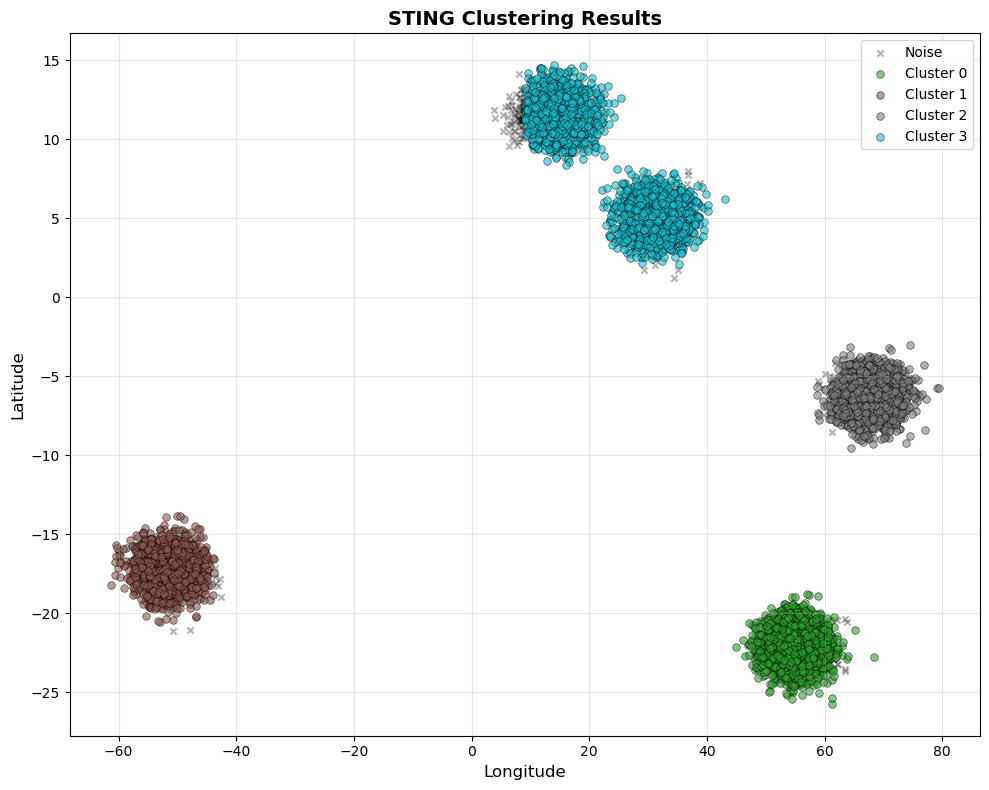

In [181]:
plt.figure(figsize=(10, 8))

unique_labels = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        mask = labels == label
        plt.scatter(X[mask, 1], X[mask, 0], 
                   c='black', marker='x', s=20, 
                   alpha=0.3, label='Noise')
    else:
        mask = labels == label
        plt.scatter(X[mask, 1], X[mask, 0],
                   c=[color], s=30, alpha=0.6,
                   edgecolors='black', linewidth=0.5,
                   label=f'Cluster {label}')

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('STING Clustering Results', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Output/sting_clusters.png', dpi=300, bbox_inches='tight')
print("\nSaved: Output/sting_clusters.png")
plt.show()

### **Grid Structure**

Saved: Output/sting_grid.png


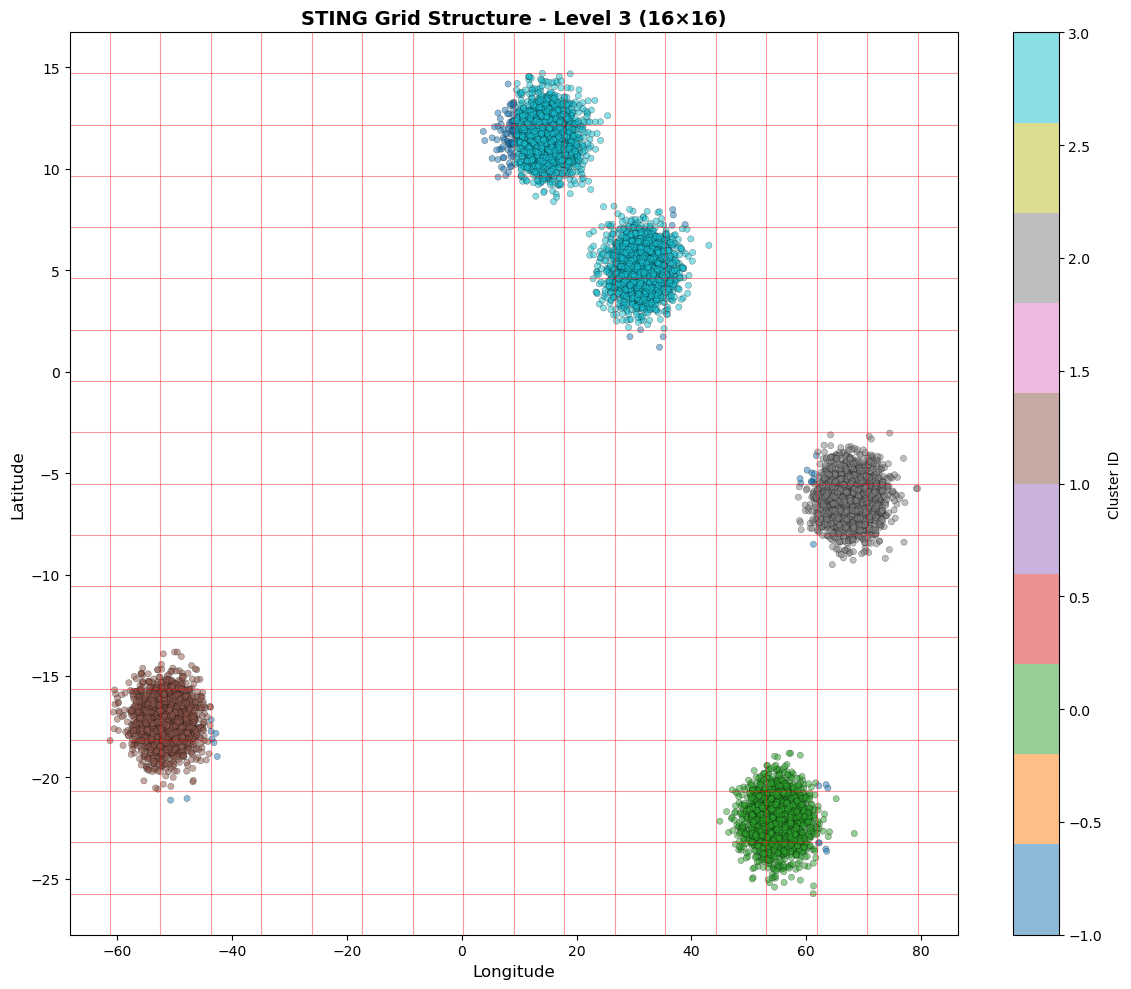

In [182]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot points
scatter = ax.scatter(X[:, 1], X[:, 0],
                    c=labels, cmap='tab10',
                    s=20, alpha=0.5,
                    edgecolors='black', linewidth=0.3)

# Draw grid lines
level_to_show = finest_level
n_cells_show = subdivision ** (level_to_show + 1)

cell_height = lat_range / n_cells_show
cell_width = lon_range / n_cells_show

for i in range(n_cells_show + 1):
    lat_line = min_lat + i * cell_height
    ax.axhline(y=lat_line, color='red', alpha=0.4, linewidth=0.8)

for j in range(n_cells_show + 1):
    lon_line = min_lon + j * cell_width
    ax.axvline(x=lon_line, color='red', alpha=0.4, linewidth=0.8)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'STING Grid Structure - Level {level_to_show} ({n_cells_show}×{n_cells_show})', 
            fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
plt.tight_layout()
plt.savefig('Output/sting_grid.png', dpi=300, bbox_inches='tight')
print("Saved: Output/sting_grid.png")
plt.show()

### **Hierarchy Levels**

Saved: Output/sting_hierarchy.png


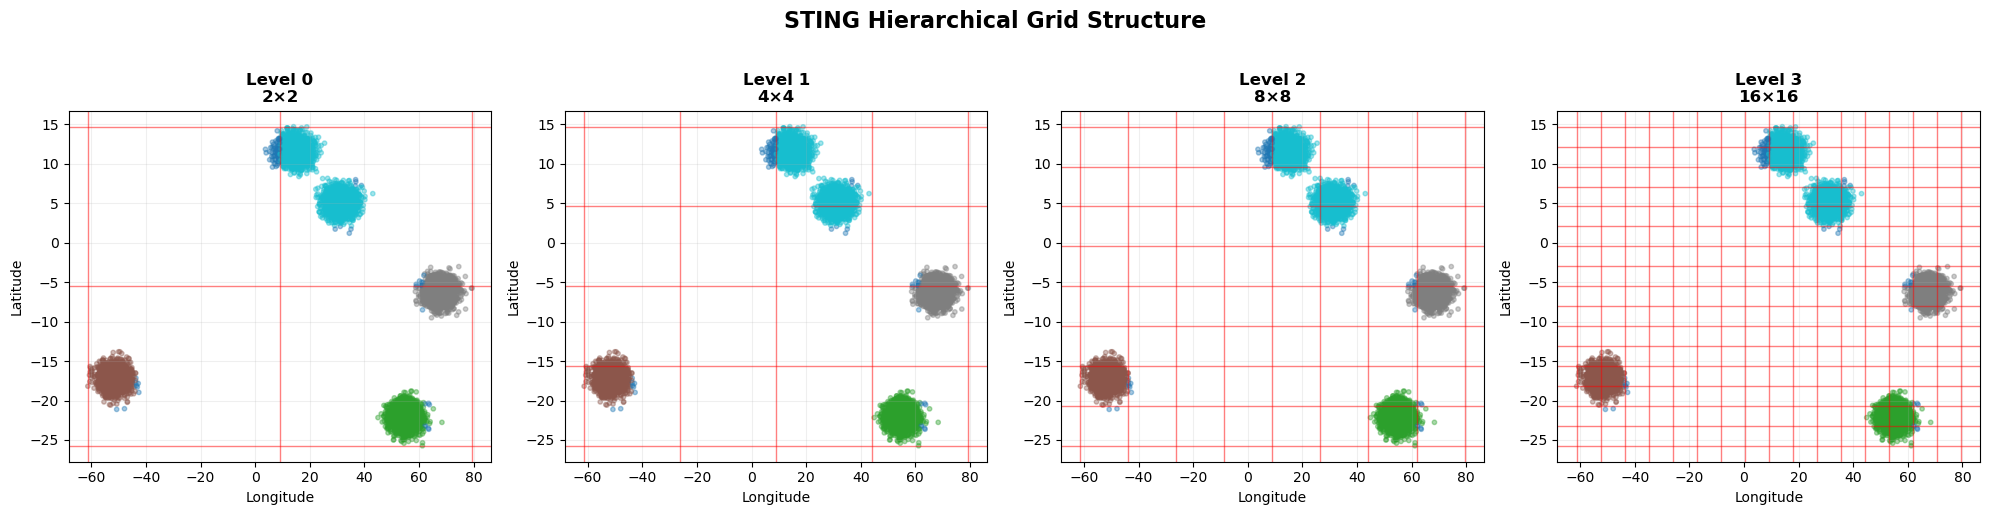

In [183]:
n_levels = len(grids)
fig, axes = plt.subplots(1, n_levels, figsize=(5*n_levels, 5))

if n_levels == 1:
    axes = [axes]

for level in range(n_levels):
    ax = axes[level]
    
    ax.scatter(X[:, 1], X[:, 0], c=labels, cmap='tab10', s=10, alpha=0.4)
    
    n_cells_level = subdivision ** (level + 1)
    cell_height = lat_range / n_cells_level
    cell_width = lon_range / n_cells_level
    
    for i in range(n_cells_level + 1):
        lat_line = min_lat + i * cell_height
        ax.axhline(y=lat_line, color='red', alpha=0.5, linewidth=1)
    
    for j in range(n_cells_level + 1):
        lon_line = min_lon + j * cell_width
        ax.axvline(x=lon_line, color='red', alpha=0.5, linewidth=1)
    
    ax.set_title(f'Level {level}\n{n_cells_level}×{n_cells_level}', fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.2)

plt.suptitle('STING Hierarchical Grid Structure', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('Output/sting_hierarchy.png', dpi=300, bbox_inches='tight')
print("Saved: Output/sting_hierarchy.png")
plt.show()

## **Clustering Evaluation**

In [188]:
# Filter noise
valid_mask = labels >= 0
X_valid = X[valid_mask]
labels_valid = labels[valid_mask]

if len(X_valid) > 0 and len(np.unique(labels_valid)) > 1:
    silhouette = silhouette_score(X_valid, labels_valid)
    davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
    calinski = calinski_harabasz_score(X_valid, labels_valid)
    
    print(f"\nQuality Metrics (excluding noise):")
    print(f"- Silhouette Score         :{silhouette:.4f} (higher is better, range: [-1, 1])")
    print(f"- Davies-Bouldin Index     :{davies_bouldin:.4f} (lower is better, range: [0, \infty))")
    print(f"- Calinski-Harabasz Score  :{calinski:.2f} (higher is better, range: [0, \infty))")

else:
    print("\nCannot compute metrics (insufficient valid clusters)")


Quality Metrics (excluding noise):
- Silhouette Score         :0.8176 (higher is better, range: [-1, 1])
- Davies-Bouldin Index     :0.2330 (lower is better, range: [0, \infty))
- Calinski-Harabasz Score  :154772.08 (higher is better, range: [0, \infty))
